# Movie Rating Prediction
### Based on Metadata and User Clusters

In [1]:
# change used width of browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# import packages
import pandas as pd
import re
import seaborn as sb
import matplotlib.pyplot as plt
import datetime

## 1. Data Exploration and Quality Estimation
### 1.1 User Ratings

In [3]:
# load ratings
df_ratings = pd.read_csv("the-movies-dataset/ratings.csv")
df_ratings.head(3)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523


In [4]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,2.602429e+07,2.602429e+07,2.602429e+07,2.602429e+07
mean,1.350371e+05,1.584911e+04,3.528090e+00,1.171258e+09
std,7.817620e+04,3.108526e+04,1.065443e+00,2.052889e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,6.716400e+04,1.073000e+03,3.000000e+00,9.907545e+08
50%,1.351630e+05,2.583000e+03,3.500000e+00,1.151716e+09
75%,2.026930e+05,6.503000e+03,4.000000e+00,1.357578e+09
max,2.708960e+05,1.762750e+05,5.000000e+00,1.501830e+09


There are no zeros.

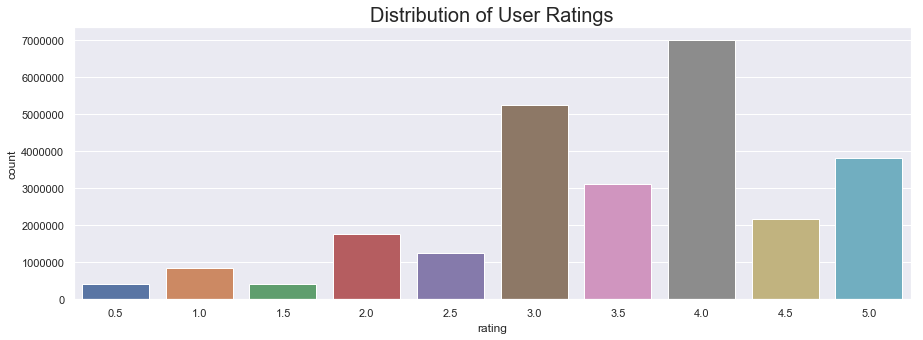

In [5]:
# create bar chart for rating
sb.set(style="whitegrid")
sb.set(rc={'figure.figsize':(15,5)})
sb.set(font_scale=1)
ax = sb.countplot(x="rating", data=df_ratings)
ax.axes.set_title("Distribution of User Ratings",fontsize=20)
plt.show()

In [6]:
# # create bar chart for timestamp
# ax = sb.countplot(x="timestamp", data=df_ratings)
# ax.axes.set_title("Distribution of Timestamps",fontsize=20)
# plt.show()

### 1.2 Movie Metadata

In [7]:
# load movies metadata
df_movies = pd.read_csv("the-movies-dataset/movies_metadata.csv")
print(df_movies.columns)
df_movies.head(3)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


C:\Python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [8]:
df_movies.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


There are missing values in revenue, runtime, vote_average and vote_count that are represented with a value of 0.

In [9]:
df_movies[["status", "id"]].groupby("status").count().sort_values("id", ascending=False)

,id
status,
Released,45014
Rumored,230
Post Production,98
In Production,20
Planned,15
Canceled,2


Some of the movies included in the data set have not been released yet. Since we are interested in movies that have been watched by people, we can discard movies with a status that is not "Released".

In [10]:
df_movies[["video", "id"]].groupby("video").count().sort_values("id", ascending=False)

,id
video,
False,45367
True,93


In [11]:
df_movies[["production_countries", "id"]].groupby("production_countries").count().sort_values("id", ascending=False)

,id
production_countries,
"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",17851
[],6282
"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2238
"[{'iso_3166_1': 'FR', 'name': 'France'}]",1654
"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",1356
...,...
"[{'iso_3166_1': 'ES', 'name': 'Spain'}, {'iso_3166_1': 'IE', 'name': 'Ireland'}, {'iso_3166_1': 'IT', 'name': 'Italy'}]",1
"[{'iso_3166_1': 'ES', 'name': 'Spain'}, {'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}, {'iso_3166_1': 'FR', 'name': 'France'}]",1
"[{'iso_3166_1': 'ES', 'name': 'Spain'}, {'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}, {'iso_3166_1': 'CA', 'name': 'Canada'}]",1


A movie can be produced in several countries, that makes it reasonable to apply one hot encoding.

In [12]:
df_movies[["production_companies", "id"]].groupby("production_companies").count().sort_values("id", ascending=False)

,id
production_companies,
[],11875
"[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]",742
"[{'name': 'Warner Bros.', 'id': 6194}]",540
"[{'name': 'Paramount Pictures', 'id': 4}]",505
"[{'name': 'Twentieth Century Fox Film Corporation', 'id': 306}]",439
...,...
"[{'name': 'Future Film Group', 'id': 777}, {'name': 'Mikado Film', 'id': 11912}, {'name': 'DeA Planeta Home Entertainment', 'id': 21138}, {'name': 'Feelmax', 'id': 68655}, {'name': 'Carolina Films', 'id': 68656}]",1
"[{'name': 'Future Film Group', 'id': 777}, {'name': 'Mediapro', 'id': 12010}]",1
"[{'name': 'Future Film Group', 'id': 777}, {'name': 'Future Films', 'id': 71496}, {'name': 'DRAX audio', 'id': 71497}]",1


A movie can be produced by several companies, that makes it reasonable to apply one hot encoding.

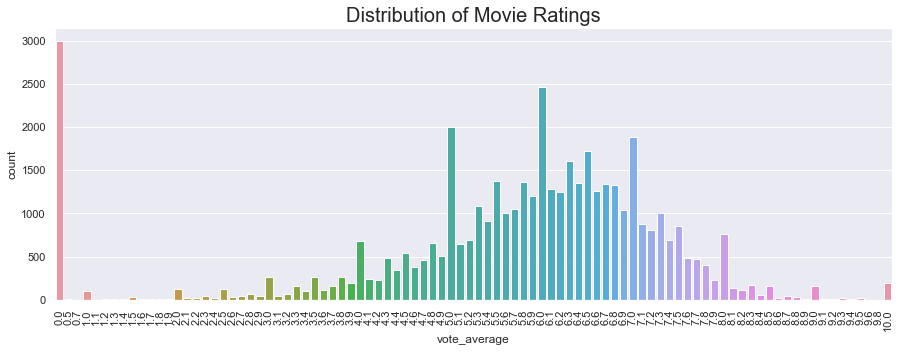

In [13]:
# create bar chart for vote average
ax = sb.countplot(x="vote_average", data=df_movies)
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax.axes.set_title("Distribution of Movie Ratings",fontsize=20)
plt.show()

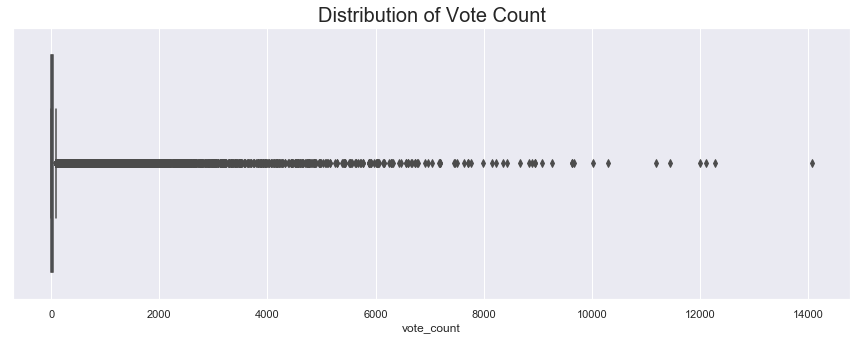

In [44]:
ax = sb.boxplot(x="vote_count", data=df_movies)
ax.axes.set_title("Distribution of Vote Count",fontsize=20)
plt.show()

In [45]:
df_movies["vote_count"].describe()

count    45014.000000
mean       110.890812
std        493.629119
min          0.000000
25%          3.000000
50%         10.000000
75%         35.000000
max      14075.000000
Name: vote_count, dtype: float64

### 1.3 Cast: Actors in Movies

In [14]:
# load credits
df_cast = pd.read_csv("the-movies-dataset/credits.csv")
df_cast.head(3)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602


In [15]:
df_cast["crew"][0]

'[{\'credit_id\': \'52fe4284c3a36847f8024f49\', \'department\': \'Directing\', \'gender\': 2, \'id\': 7879, \'job\': \'Director\', \'name\': \'John Lasseter\', \'profile_path\': \'/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f4f\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12891, \'job\': \'Screenplay\', \'name\': \'Joss Whedon\', \'profile_path\': \'/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f55\', \'department\': \'Writing\', \'gender\': 2, \'id\': 7, \'job\': \'Screenplay\', \'name\': \'Andrew Stanton\', \'profile_path\': \'/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f5b\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12892, \'job\': \'Screenplay\', \'name\': \'Joel Cohen\', \'profile_path\': \'/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f61\', \'department\': \'Writing\', \'gender\': 0, \'id\': 12893, \'job\': \'Screenplay\', \'name\': \'A

The number of people working on a movie is really huge. We can, however, extract the direcetor from the crew column. These values could then be one hot encoded.

In [16]:
df_cast["cast"][0]

"[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4t

The number of people acting in a movie is really huge, but smaller than the crew. They could be one hot encoded.

### 1.4 Keywords
Keywords are similar to genres, but more diverse.

In [17]:
# load keywords
df_keywords = pd.read_csv("the-movies-dataset/keywords.csv")
df_keywords.head(3)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."


The keywords could be used additionally to the metadata, but using them creates a huge amount of additional features (since one hot encoding could be used very well in this case).  
We could also extract the most common keywords and only use those, but I would recommend to only use them as additional features later on, if at all.

<b>Conclusion:</b> A lot of columns can be one hot encoded, using all of them results in a very large feature space. Therefore we can start with less attributes and add more if necessary.

## 2. Data Preparation
### 2.1 Preprocessing

In [18]:
# # convert timestamp format (if we want to keep the timestamp as a feature, so far it is not needed in our use case)
# df_ratings["timestamp"] = [ datetime.datetime.fromtimestamp(row.timestamp) for index, row in df_ratings.iterrows() ] 

In [29]:
len(df_movies)

45466

In [30]:
# # drop irrelevant movie metadata columns: overview, poster_path, tagline
df_movies.drop(columns=["overview", "poster_path", "tagline", "revenue", "imdb_id", "overview", "popularity", "title", "original_title", "release_date", "vote_count", "video"])

In [32]:
# filter movies on Status == 'Released' and drop status column
df_movies = df_movies[df_movies["status"] == 'Released']
df_movies.drop(columns=["status"])
len(df_movies)

45014

In [21]:
# normalize "belongs to collection" and "homepage" to True (1) or False (0)

In [22]:
# one hot encoding for "production_company" and "production_countries" and "spoken_languages" 

In [23]:
# one hot encoding of genres (and other list columns)

In [24]:
# split genres
# aggregate movie genres for clustering and normalize values

In [ ]:
# combine with cast: actors (one hot encoded) and director (extract from crew)

In [ ]:
# combine with user data

### 2.2 Split into training and Test Data for Regression

In [25]:
# split into training and test data (10 cross fold for rating?)